<a href="https://colab.research.google.com/github/kbyshiro/CMAPSS_tasks/blob/main/LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## データの前処理

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# load necessary packages and view available data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
sns.set()
# print(os.listdir("../input/cmapass"))
# data_path = "../input/cmapass"
print(os.listdir("/content/drive/My Drive/CMAPSSData"))
data_path = "/content/drive/My Drive/CMAPSSData"

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

['readme.txt', 'Damage Propagation Modeling.pdf', 'RUL_FD001.txt', 'RUL_FD004.txt', 'RUL_FD002.txt', 'test_FD004.txt', 'test_FD002.txt', 'train_FD001.txt', 'RUL_FD003.txt', 'test_FD001.txt', 'test_FD003.txt', 'train_FD004.txt', 'train_FD003.txt', 'train_FD002.txt']


In [3]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [4]:
# load data
train= pd.read_csv(os.path.join(data_path, 'train_FD001.txt'), sep=" ", header=None)
test = pd.read_csv(os.path.join(data_path, 'test_FD001.txt'), sep=" ", header=None)
rul_test = pd.read_csv(os.path.join(data_path, 'RUL_FD001.txt'),sep=" ",  header=None)
print("train shape: ", train.shape, "test shape: ", test.shape)
# drop pesky NULL columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
# name columns
train.columns = column_names
test.columns = column_names
# train[train['UnitNumber'] == 1].head(5)
test[test['UnitNumber'] == 1].head(5)

train shape:  (20631, 28) test shape:  (13096, 28)


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [5]:
# this section calculates Remaining Useful Life (RUL) in T-minus notation for the training data
# find the last cycle per unit number
def conv_cycle_to_RUL(data):
    max_cycle = data.groupby('UnitNumber')['Cycle'].max().reset_index()
    max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
    # merge the max cycle back into the original frame
    data_merged = data.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
    # calculate RUL for each row
    Target_Remaining_Useful_Life = data_merged["MaxOfCycle"] - data_merged["Cycle"]
    data_with_target = data_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life
    # remove unnecessary column
    data_with_target = data_merged.drop("MaxOfCycle", axis=1)
    return data_with_target
train_with_target = conv_cycle_to_RUL(train)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [6]:
# create test_with_target
test_with_target = test
rul_test.columns=["RUL", "None"]
rul_test.drop("None", axis=1, inplace=True)
rul_test["UnitNumber"]=rul_test.index+1
rul = pd.DataFrame(test.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
rul_test["RUL_failed"]=rul_test["RUL"]+rul["max"]
rul_test.drop("RUL", axis=1, inplace=True)
test_with_target=test_with_target.merge(rul_test,on=['UnitNumber'],how='left')
test_with_target["Target_Remaining_Useful_Life"]=test_with_target['RUL_failed']-test_with_target['Cycle']
test_with_target.drop("RUL_failed", axis=1, inplace=True)
test_with_target.head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [7]:
# now it's time to clear out target leakage
print(train_with_target.shape)
un_train = train_with_target['UnitNumber']
un_test = test_with_target['UnitNumber']
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
test_no_leakage = test_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape, test_no_leakage.shape)

(20631, 27)
(20631, 22) (13096, 22)


In [8]:
# sensor slection
drop_idx = ['Sensor_'+str(i) for i in [1, 5, 6, 10, 16, 18, 19]]
train_no_leakage.drop(drop_idx, axis=1, inplace=True)
test_no_leakage.drop(drop_idx, axis=1, inplace=True)

In [9]:
y_train = train_no_leakage['Target_Remaining_Useful_Life']
y_test = test_no_leakage['Target_Remaining_Useful_Life']

In [10]:
#[0, 1]で正規化
train_no_leakage = train_no_leakage.drop('Target_Remaining_Useful_Life', axis=1)
test_no_leakage = test_no_leakage.drop('Target_Remaining_Useful_Life', axis=1)
X_min, X_max = train_no_leakage.min(), train_no_leakage.max()
train_norm = (train_no_leakage-X_min)/(X_max-X_min)
test_norm = (test_no_leakage-X_min)/(X_max-X_min)
train_with_unit = pd.concat([un_train, train_norm, y_train], axis=1)
test_with_unit = pd.concat([un_test, test_norm, y_test], axis=1)
test_with_unit.head(5)

,UnitNumber,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,141
2,1,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,140
3,1,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,139
4,1,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,138


RULに蓋をする(130で制限)

In [11]:

# RULに制限を設ける。
RUL_limit = 130
# print(np.minimum(y_train, RUL_limit))
train_with_unit['Target_Remaining_Useful_Life']  = np.minimum(y_train, RUL_limit)
test_with_unit['Target_Remaining_Useful_Life']  = np.minimum(y_test, RUL_limit)
train_with_unit.head(5)

,UnitNumber,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,130
1,1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,130
2,1,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,130
3,1,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,130
4,1,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,130


In [12]:
train_with_unit.shape

(20631, 16)

## データローダーの準備

In [16]:
#tuning parameters
window_size = 30
batch_size = 100
cut_size = 10

In [17]:
#slice along window
def prepare_seq_dataset(input_data, ws, cs):
    #X.size= (n-ws, cs, ws/cs, n_feautures)

    n_max = input_data['UnitNumber'].max()
    n = input_data.shape[0]
    width = int(ws/cs)
    # X, y = [[0]*cs for _ in range(n-ws)], [[0] for _ in range(n-ws)]
    X, y = [], []
    for k in range(n_max):
      tmp_data = input_data[input_data['UnitNumber']==k+1].drop('UnitNumber', axis=1)
      tmp_data = np.array(tmp_data)
      n = len(tmp_data)
      for i in range(n-ws):
          X.append([tmp_data[i+(j)*width:i+(j+1)*width, :-1] for j in range(cs)])
          y.append(tmp_data[i+ws, -1])
    return torch.tensor(X).float(), torch.tensor(y).float()

class DataSet:
    def __init__(self, X, t):
        self.X = X # 入力
        self.t = t # 出力

    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.t[index]
    
X_seq_train, y_seq_train = prepare_seq_dataset(train_with_unit, window_size, cut_size)
X_seq_test, y_seq_test = prepare_seq_dataset(test_with_unit, window_size, cut_size)
dataset_train = DataSet(X_seq_train, y_seq_train)
dataset_test = DataSet(X_seq_test, y_seq_test)
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size= batch_size)

In [18]:
dataset_train.X.size()

torch.Size([17631, 10, 3, 14])

## 学習モデルの構築
LSTM1(以後L1)とCNN層(以後C1）を並列で学習させ、
それをLSTM2(L2）でそれぞれsumしたものを通し、最後に全結合層で出力する。

In [19]:
#tuning parameters
L1_input_size= dataset_train.X.shape[2]*dataset_train.X.shape[3]
L1_hidden_size = 21

conv_size = [3, 2]
conv_stride = [2, 2]
conv_out_size = 3
maxpool_size = [1, 2]
maxpool_stride = [1, 2]

L2_input_size = L1_hidden_size
L2_hidden_size = 10
output_size = 1


In [20]:
class DAG_CNN_LSTM_Regressor(nn.Module):
  def __init__(self,L1_input_size, L1_hidden_size, conv_size, 
              conv_stride, maxpool_size, maxpool_stride, L2_input_size, L2_hidden_size, output_size):
    super().__init__()
    #L1
    self.L1_input_size = L1_input_size
    self.L1_hidden_size = L1_hidden_size
    self.LSTM1 = nn.LSTM(self.L1_input_size, self.L1_hidden_size)

    # CNN
    self.conv_size = conv_size
    self.conv_stride = conv_stride
    self.conv_out_size = conv_out_size
    self.maxpool_size = maxpool_size
    self.maxpool_stride = maxpool_stride
    self.CNN = nn.Sequential(nn.Conv2d(1, self.conv_out_size, kernel_size=self.conv_size,
                                       stride=self.conv_stride, padding=[1, 1]), 
                              nn.MaxPool2d(self.maxpool_size, self.maxpool_stride), 
                              nn.Flatten())

    #L2
    self.L2_input_size = L2_input_size
    self.L2_hidden_size = L2_hidden_size
    self.LSTM2 = nn.LSTM(self.L2_input_size, self.L2_hidden_size)

    # fully connected layer
    self.output_size = output_size
    self.Linear = nn.Linear(self.L2_hidden_size, self.output_size)
  
  def init_hidden(self, batch_size):
        hidden_state1 = torch.zeros(1, batch_size, self.L1_hidden_size)
        cell_state1 = torch.zeros(1, batch_size, self.L1_hidden_size)
        self.hidden1 = (hidden_state1, cell_state1)
        hidden_state2 = torch.zeros(1, batch_size, self.L2_hidden_size)
        cell_state2 = torch.zeros(1, batch_size, self.L2_hidden_size)
        self.hidden2 = (hidden_state2, cell_state2)


  def forward(self, x):
    batch_size, seq_size, width, n_features = x.size()

    #LSTM1
    #input size = (seq_size, batch_size, width*n_features)
    #output_size = (seq_size, batch_size, hidden_size)
    out1, self.hidden1 = self.LSTM1(torch.transpose(x, 0, 1).reshape(seq_size, batch_size, -1), self.hidden1)
    
    #CNN
    #input size = (seq_size, 1, n_features, width)
    #output_size = (seq_size, batch_size, hidden_size)
    out2 = torch.zeros((batch_size,seq_size, self.L1_hidden_size ))
    for i in range(batch_size):
      out2[i] = self.CNN(x[i].view(seq_size, 1, n_features, width))
    # print(out2.size())
    
    # combine outputs
    out = out1+ torch.transpose(out2, 0, 1)
    #LSTM2
    _, self.hidden2 = self.LSTM2(out, self.hidden2)
    
    #fully connecter
    out = self.Linear(self.hidden2[0][0].view(batch_size, -1))
    return out

## 訓練開始！


In [22]:
# training epoches

n_epoches = 100

In [23]:
#training
model = DAG_CNN_LSTM_Regressor(L1_input_size, L1_hidden_size, conv_size, 
                     conv_stride, maxpool_size, maxpool_stride, L2_input_size, L2_hidden_size, output_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.005)
RMSE_his = []
for epoch in range(n_epoches):
    loss_all = []
    for i, data in enumerate(dataloader):
        x_batch, y_batch = data
        optimizer.zero_grad()
        model.init_hidden(len(x_batch))
        #calc 
        y_pred = model(x_batch)
        loss = loss_fn(y_pred.view(-1), y_batch)
        loss_all.append(loss.item())
        # update
        loss.backward()
        optimizer.step()
    RMSE_his.append(np.sqrt(sum(loss_all)/len(loss_all)))
    if epoch%10 == 9:
        print('epoch: {0:3}: RMSE: {1:10.8f}'.format(epoch+1, RMSE_his[epoch]))
print('Done!')

epoch:  10: RMSE: 46.57784317
epoch:  20: RMSE: 43.46076484
epoch:  30: RMSE: 43.45394962
epoch:  40: RMSE: 26.85400732
epoch:  50: RMSE: 20.81821844
epoch:  60: RMSE: 18.03719938
epoch:  70: RMSE: 16.76566851
epoch:  80: RMSE: 16.12030406
epoch:  90: RMSE: 15.58332250
epoch: 100: RMSE: 15.27081709
Done!


In [24]:
y_true = dataset_test.t
with torch.no_grad():
    model.init_hidden(dataset_test.X.size(0))
    y_pred = model(dataset_test.X)
    mseloss = loss_fn(y_pred.view(-1), y_true)
print('RMSE: {}'.format(np.sqrt(mseloss)))

RMSE: 15.3301362991333


## 結果の表示

Text(0, 0.5, 'RMSE')

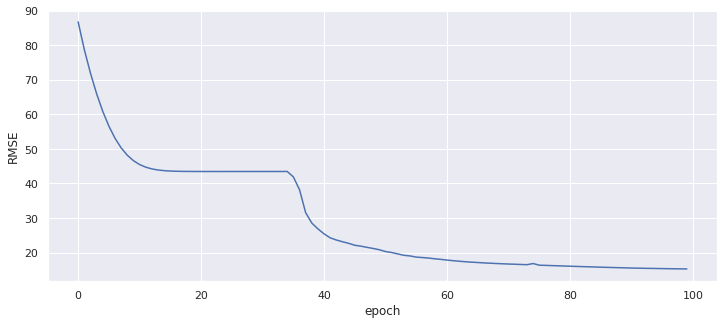

In [26]:
f = plt.figure(figsize=(12, 5))
plt.plot(RMSE_his, label='RMSE')
plt.xlabel('epoch')
plt.ylabel('RMSE')

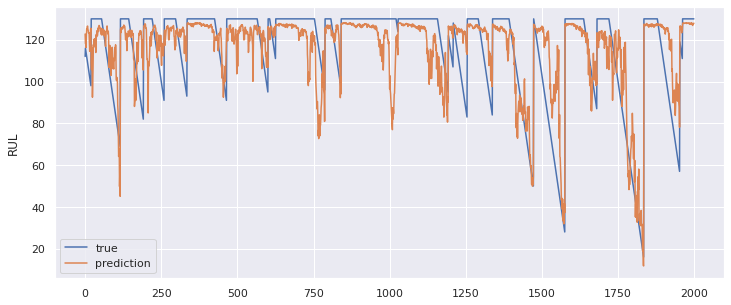

In [28]:
f= plt.figure(figsize=(12, 5))
plt.plot(y_true[:2000], label='true')
plt.plot(y_pred[:2000], label='prediction')
plt.ylabel('RUL')
plt.legend()

No handles with labels found to put in legend.


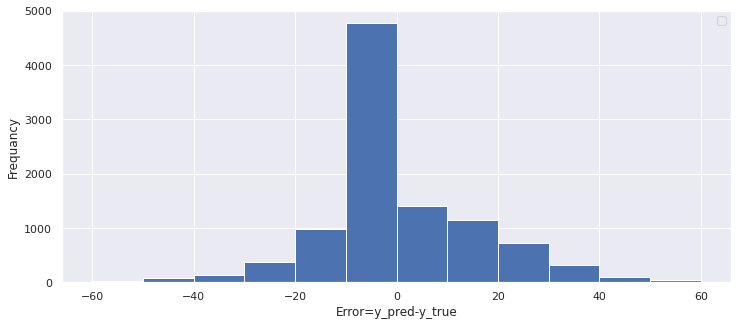

In [31]:
f= plt.figure(figsize=(12, 5))
plt.hist(y_pred.view(-1)-y_true, range=(-60, 60), bins=12)
plt.xlabel('Error=y_pred-y_true')
plt.ylabel('Frequancy')
plt.legend()

In [182]:
x = torch.rand(3, 2)
print(x)
print(x.transpose(0,1))

tensor([[0.3060, 0.8926],
        [0.8915, 0.1161],
        [0.1687, 0.3280]])
tensor([[0.3060, 0.8915, 0.1687],
        [0.8926, 0.1161, 0.3280]])
